In [5]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
from utils import device, get_num_correct, RunBuilder
from network import Network

In [6]:
# declare the transforms
data_transforms = {
    'train': transforms.Compose([
        # add augmentations
        transforms.ColorJitter(brightness=0.25, saturation=0.1),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        # The output of torchvision datasets are PILImage images of range [0, 1].
        # We transform them to Tensors of normalized range [-1, 1]
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])
}

In [8]:
# choose the training and test datasets
train_set = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=data_transforms['train']
)
test_set = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=data_transforms['test']
)

Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


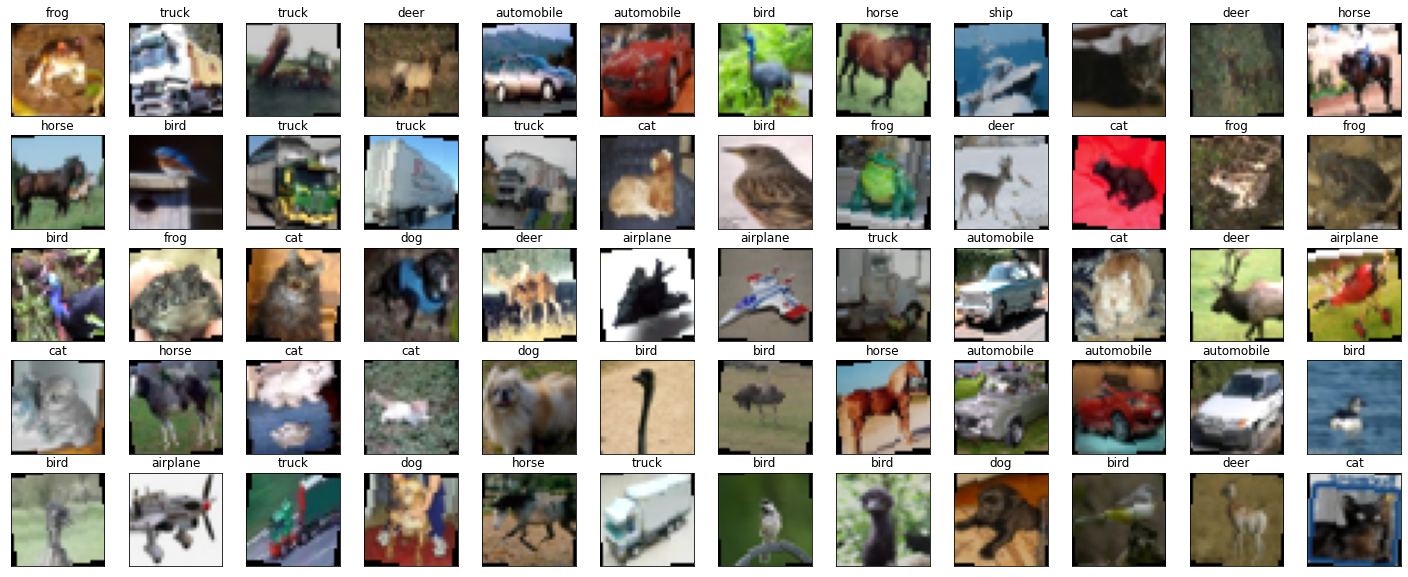

In [10]:
# to see how our augmented data looks like
sample_loader = torch.utils.data.DataLoader(train_set, batch_size=64)
images, labels = next(iter(sample_loader))  # obtain one batch of augmented data 
images = images.numpy()

# plot the images in the batch, along with corresponding labels
fig = plt.figure(figsize=(25, 10))
for i in np.arange(60):
    ax = fig.add_subplot(5, 12, i+1, xticks=[], yticks=[])
    img = np.squeeze(np.transpose(images[i], (1,2,0)))  # B*C*H*W --> H*W*C
    img = img/2 + 0.5  # un-normalize the image
    ax.imshow(img)
    ax.set_title(train_set.classes[labels[i].item()])

plt.show()
fig.savefig('visualizations/augmented_samples.png', bbox_inches='tight')
plt.close()

In [11]:
valid_size = 0.5  # percentage of test_set to be used as validation

# obtain training indices that will be used for validation
num_test = len(test_set)
indices = list(range(num_test))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_test))
test_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare the data loaders
valid_loader = torch.utils.data.DataLoader(test_set, batch_size=128, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, sampler=test_sampler, num_workers=1)

In [12]:
# for hyper-parameter search
from collections import OrderedDict

params = OrderedDict(
    lr = [0.01, 0.003, 0.001],
    batch_size = [64, 128, 256, 512]
)

In [13]:
criterion = nn.CrossEntropyLoss()  # loss function (categorical cross-entropy)

# iterate through the cross product of hyper-parameters defined in params
for run in RunBuilder.get_runs(params):
    print(f'\n{run}')
    model = Network().to(device)  # initialize the NN
    # load the train set
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=run.batch_size,
        shuffle=True,
        num_workers=1
    )
    
    optimizer = optim.Adam(model.parameters(), lr=run.lr)  # specify the optimizer

    comment = f'-{run}'  # will be used for naming the runs based on each run's hyper-parameters
    tb = SummaryWriter(comment=comment)

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf  # set initial minimum to infinity

    num_epochs = 30  # number of epochs used for training
    for epoch in range(num_epochs):
        train_loss, train_correct = 0, 0  # wil be used to track the running loss and correct
        ###################
        # train the model #
        ###################
        model.train()  # set the model to train mode
        for batch in train_loader:
            images, labels = batch[0].to(device), batch[1].to(device)  # load the batch to the available device (cpu/gpu)
            preds = model(images)  # forward pass
            loss = criterion(preds, labels)  # calculate loss
            optimizer.zero_grad()  # clear accumulated gradients from the previous pass
            loss.backward()  # backward pass
            optimizer.step()  # perform a single optimization step

            train_loss += loss.item() * run.batch_size  # update the running loss
            train_correct += get_num_correct(preds, labels)  # update running num correct

        # add train loss and train accuracy for the current epoch to tensorboard
        tb.add_scalar('Train Loss', train_loss, epoch)
        tb.add_scalar('Train Accuracy', train_correct/len(train_set), epoch)

        model.eval()  # set the model to evaluation mode
        with torch.no_grad():  # turn off grad tracking, as we don't need gradients for validation
            valid_loss, valid_correct = 0, 0  # will be used to track the running validation loss and correct
            ######################
            # validate the model #
            ######################
            for batch in valid_loader:
                images, labels = batch[0].to(device), batch[1].to(device)  # load the batch to the available device
                preds = model(images)  # forward pass
                loss = criterion(preds, labels)  # calculate the loss  

                valid_loss += loss.item() * 128  # update the running loss
                valid_correct += get_num_correct(preds, labels)  # update running num correct

            # add validation loss and validation accuracy for the current epoch to tensorboard
            tb.add_scalar('Validation Loss', valid_loss, epoch)
            tb.add_scalar('Validation Accuracy', valid_correct/len(valid_loader.sampler), epoch)

            # print training/validation statistics
            # calculate average loss over an epoch
            train_loss = train_loss/len(train_set)
            valid_loss = valid_loss/len(valid_loader.sampler)
            print(f'Epoch {epoch+1:2d}: Training Loss: {train_loss:.6f} Validation Loss: {valid_loss:.6f}')

            # save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f'\t  valid_loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f})  saving model...')
                torch.save(model.state_dict(), f'./models/with_aug/model-{run}.ckpt')
                valid_loss_min = valid_loss

            # load the model with least validation loss i.e., load the one which was saved most recently
            model.load_state_dict(
                torch.load(
                    f'./models/with_aug/model-{run}.ckpt',
                    map_location=device
                )
            )

            test_loss, test_correct = 0, 0  # will be used to track the running test loss and correct
            ##################
            # test the model #
            ##################
            for batch in test_loader:
                images, labels = batch[0].to(device), batch[1].to(device)  # load the batch to the available device
                preds = model(images)  # forward pass
                loss = criterion(preds, labels)  # calculate the loss

                test_loss += loss.item() * 128  # update the running loss
                test_correct += get_num_correct(preds, labels)  # update running num correct

            # add test loss and test accuracy for the current epoch to tensorboard
            tb.add_scalar('Test Loss', test_loss, epoch)
            tb.add_scalar('Test Accuracy', test_correct/len(test_loader.sampler), epoch)

        # iterate the parameters' weights and it's grads and plot their historgrams to tensorboard
        # (will be helpful for checking if the model is having the vanishing gradient problem)
        for name, weight in model.named_parameters():
            tb.add_histogram(name, weight, epoch)
            tb.add_histogram(f'{name}.grad', weight.grad, epoch)



run(lr=0.01, batch_size=64)
Epoch  1: Training Loss: 1.861126 Validation Loss: 1.516536
	  valid_loss decreased (inf --> 1.516536)  saving model...
Epoch  2: Training Loss: 1.522125 Validation Loss: 1.425634
	  valid_loss decreased (1.516536 --> 1.425634)  saving model...
Epoch  3: Training Loss: 1.383487 Validation Loss: 1.255973
	  valid_loss decreased (1.425634 --> 1.255973)  saving model...
Epoch  4: Training Loss: 1.309598 Validation Loss: 1.225471
	  valid_loss decreased (1.255973 --> 1.225471)  saving model...
Epoch  5: Training Loss: 1.247685 Validation Loss: 1.088400
	  valid_loss decreased (1.225471 --> 1.088400)  saving model...
Epoch  6: Training Loss: 1.209945 Validation Loss: 1.022418
	  valid_loss decreased (1.088400 --> 1.022418)  saving model...
Epoch  7: Training Loss: 1.166629 Validation Loss: 1.017256
	  valid_loss decreased (1.022418 --> 1.017256)  saving model...
Epoch  8: Training Loss: 1.135084 Validation Loss: 1.006798
	  valid_loss decreased (1.017256 --> 1.0